# Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

# Load Data

In [35]:
# Load the data
file_path = "fic_epita_kantar_codes.csv"
data_codes = pd.read_csv(file_path, sep=';')

In [36]:
# Select relevant columns
columns_of_interest = [
    "A9_1_slice", "A9_2_slice", "A9_3_slice", "A9_4_slice", "A9_5_slice",
    "A9_6_slice", "A9_7_slice", "A9_8_slice", "A9_9_slice", "A9_10_slice",
    "A9_11_slice", "A9_12_slice", "A9_13_slice", "A9_14_slice", "A9_15_slice",
    "A9_16_slice", "A10_1_slice", "A10_2_slice", "A10_3_slice", "A10_4_slice",
    "A10_5_slice", "A10_6_slice", "A10_7_slice", "A10_8_slice",
    "A11_1_slice", "A11_2_slice", "A11_3_slice", "A11_4_slice", "A11_5_slice",
    "A11_6_slice", "A11_7_slice", "A11_8_slice", "A11_9_slice", "A11_10_slice",
    "A11_11_slice", "A11_12_slice", "A11_13_slice"
]
subset_data = data_codes[columns_of_interest]

In [37]:
# Check for missing values
missing_values = subset_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Data type analysis
data_types = subset_data.dtypes
print("\nData Types:\n", data_types)

# Summary statistics
summary_stats = subset_data.describe()
print("\nSummary Statistics:\n", summary_stats)

# Check for outliers
outliers = subset_data.apply(zscore).abs() > 3
print("\nOutliers:\n", outliers)

Missing Values:
 A9_1_slice      0
A9_2_slice      0
A9_3_slice      0
A9_4_slice      0
A9_5_slice      0
A9_6_slice      0
A9_7_slice      0
A9_8_slice      0
A9_9_slice      0
A9_10_slice     0
A9_11_slice     0
A9_12_slice     0
A9_13_slice     0
A9_14_slice     0
A9_15_slice     0
A9_16_slice     0
A10_1_slice     0
A10_2_slice     0
A10_3_slice     0
A10_4_slice     0
A10_5_slice     0
A10_6_slice     0
A10_7_slice     0
A10_8_slice     0
A11_1_slice     0
A11_2_slice     0
A11_3_slice     0
A11_4_slice     0
A11_5_slice     0
A11_6_slice     0
A11_7_slice     0
A11_8_slice     0
A11_9_slice     0
A11_10_slice    0
A11_11_slice    0
A11_12_slice    0
A11_13_slice    0
dtype: int64

Data Types:
 A9_1_slice      int64
A9_2_slice      int64
A9_3_slice      int64
A9_4_slice      int64
A9_5_slice      int64
A9_6_slice      int64
A9_7_slice      int64
A9_8_slice      int64
A9_9_slice      int64
A9_10_slice     int64
A9_11_slice     int64
A9_12_slice     int64
A9_13_slice     int64
A9_1

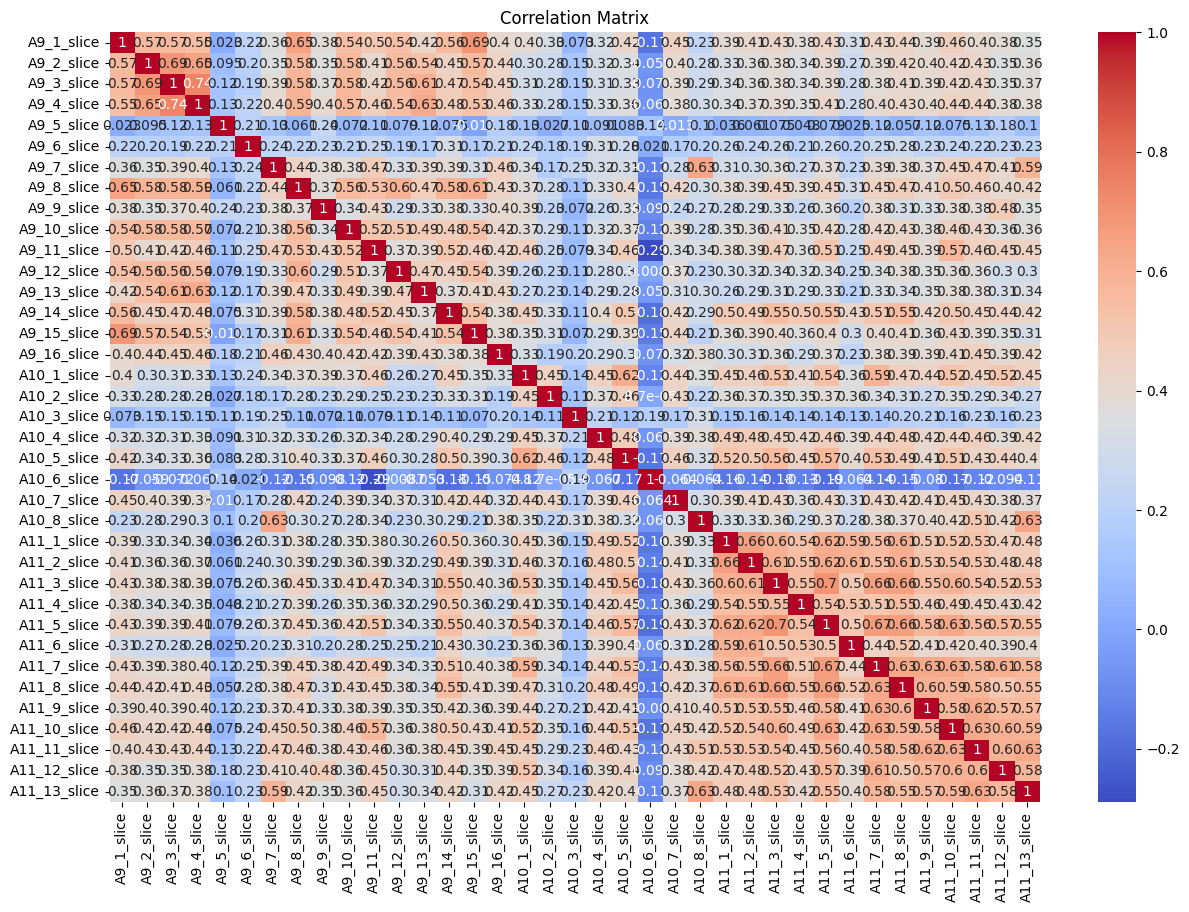

In [38]:
# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(subset_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [39]:
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

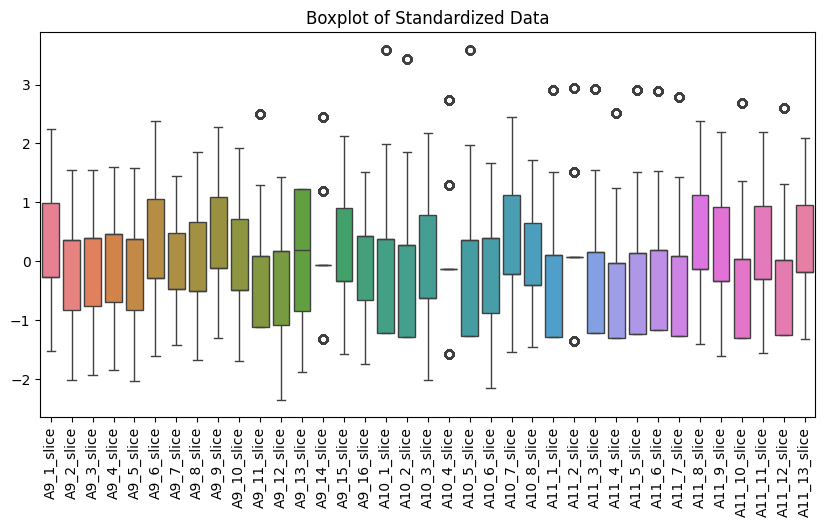

In [40]:
# Check if clustering is appropriate (variance and distribution)
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(scaled_data, columns=columns_of_interest))
plt.xticks(rotation=90)
plt.title("Boxplot of Standardized Data")
plt.show()

# Clustering

In [41]:
# Function to evaluate clustering
def evaluate_clustering(labels, data):
    if len(set(labels)) > 1:  # At least 2 clusters
        silhouette = silhouette_score(data, labels)
        davies_bouldin = davies_bouldin_score(data, labels)
        calinski_harabasz = calinski_harabasz_score(data, labels)
    else:
        silhouette, davies_bouldin, calinski_harabasz = None, None, None
    return silhouette, davies_bouldin, calinski_harabasz

results = {}

## Kmeans

In [42]:
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

def grid_search_kmeans(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        kmeans = KMeans(**params, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)
        score = evaluate_clustering(kmeans_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for KMeans
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 300],
        'n_init': [10, 20]
    }
    
    pca_results[n_components] = grid_search_kmeans(reduced_data, param_grid)

results['K-Means'] = pca_results

## Hierarchical Clustering

In [43]:
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

def grid_search_agglo(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        agglo = AgglomerativeClustering(**params)
        agglo_labels = agglo.fit_predict(data)
        score = evaluate_clustering(agglo_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'linkage': ['ward', 'complete', 'average', 'single']
    }

    pca_results[n_components] = grid_search_agglo(reduced_data, param_grid)

results['Agglomerative'] = pca_results

## DBSCAN

In [44]:
from sklearn.model_selection import ParameterGrid

def grid_search_dbscan(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        dbscan = DBSCAN(**params)
        dbscan_labels = dbscan.fit_predict(data)
        score = evaluate_clustering(dbscan_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'eps': [0.5, 1.0, 1.5, 2.0],
        'min_samples': [3, 5, 10, 15],
    }

    pca_results[n_components] = grid_search_dbscan(reduced_data, param_grid)

results['DBSCAN'] = pca_results

## Gaussian Mixture Model

In [45]:
from sklearn.model_selection import ParameterGrid

def grid_search_gmm(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        gmm = GaussianMixture(**params)
        gmm_labels = gmm.fit_predict(data)
        score = evaluate_clustering(gmm_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'n_components': [3, 4, 5, 6, 7, 8, 9],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'random_state': [42]
    }

    pca_results[n_components] = grid_search_gmm(reduced_data, param_grid)

results['GMM'] = pca_results

## Spectral Clustering

In [46]:
from sklearn.model_selection import ParameterGrid

def grid_search_spectral(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        spectral = SpectralClustering(**params)
        spectral_labels = spectral.fit_predict(data)
        score = evaluate_clustering(spectral_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'affinity': ['nearest_neighbors'],
        'random_state': [42]
    }

    pca_results[n_components] = grid_search_spectral(reduced_data, param_grid)

results['Spectral'] = pca_results

## Results

In [47]:
# Display best score and hyperparameters for each method
best_hyperparameters = {}
for method, pca_comps in results.items():
    for pca in pca_comps:
        best_score = max(pca_comps[pca], key=lambda x: x['score'][0])  # Get the score with the highest first value
        if method not in best_hyperparameters:
            best_hyperparameters[method] = {'pca': pca, 'params': best_score['params'], 'score': best_score['score']}
        else:
            current_best_score = best_hyperparameters[method]['score']
            if best_score['score'] > current_best_score:
                best_hyperparameters[method] = {'pca': pca, 'params': best_score['params'], 'score': best_score['score']}

print("Best Hyperparameters:")
for method, params in best_hyperparameters.items():
    print(f"Method: {method}, PCA Components: {params['pca']}, Parameters: {params['params']}, Score: {params['score']}")


Best Hyperparameters:
Method: K-Means, PCA Components: 2, Parameters: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3, 'n_init': 10}, Score: (0.40443286145861834, 0.8298231240610466, 5212.267717603587)
Method: Agglomerative, PCA Components: 2, Parameters: {'linkage': 'average', 'n_clusters': 3}, Score: (0.4057401636000236, 0.5352545178441465, 841.8433707196778)
Method: DBSCAN, PCA Components: 2, Parameters: {'eps': 1.0, 'min_samples': 5}, Score: (0.4496954069972326, 4.554114205204604, 1.4256395627023446)
Method: GMM, PCA Components: 2, Parameters: {'covariance_type': 'spherical', 'n_components': 3, 'random_state': 42}, Score: (0.4091182669177925, 0.8263318291705856, 4963.319464247499)
Method: Spectral, PCA Components: 2, Parameters: {'affinity': 'nearest_neighbors', 'n_clusters': 3, 'random_state': 42}, Score: (0.3972480352144417, 0.85240793427272, 5115.223573515349)


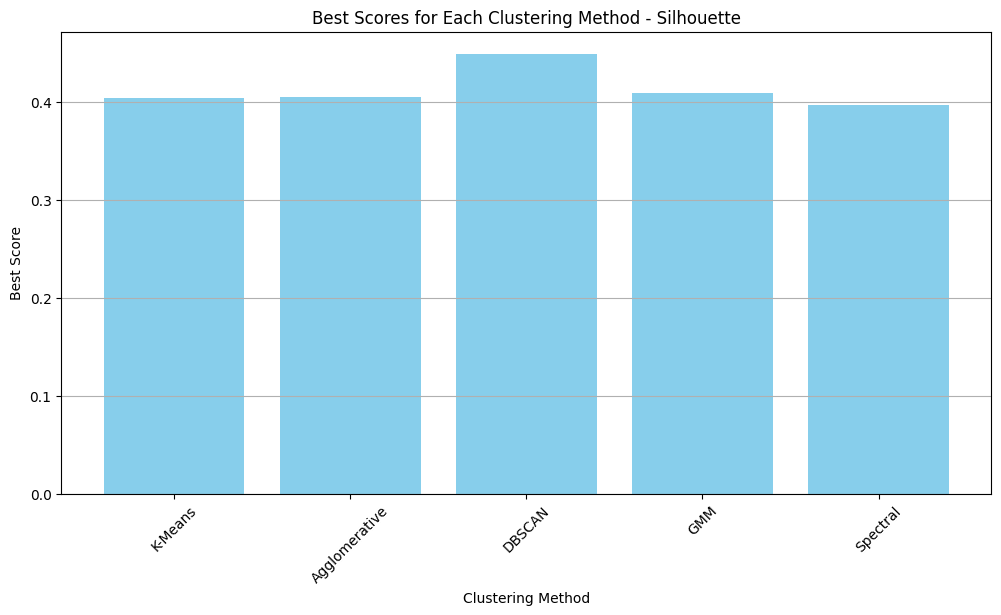

In [48]:
import matplotlib.pyplot as plt

# Data to plot
methods = list(best_hyperparameters.keys())
pca_components = [best_hyperparameters[method]['pca'] for method in methods]
scores = [best_hyperparameters[method]['score'][0] for method in methods]  # Using the first score for plotting

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('Best Scores for Each Clustering Method - Silhouette')
plt.xlabel('Clustering Method')
plt.ylabel('Best Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


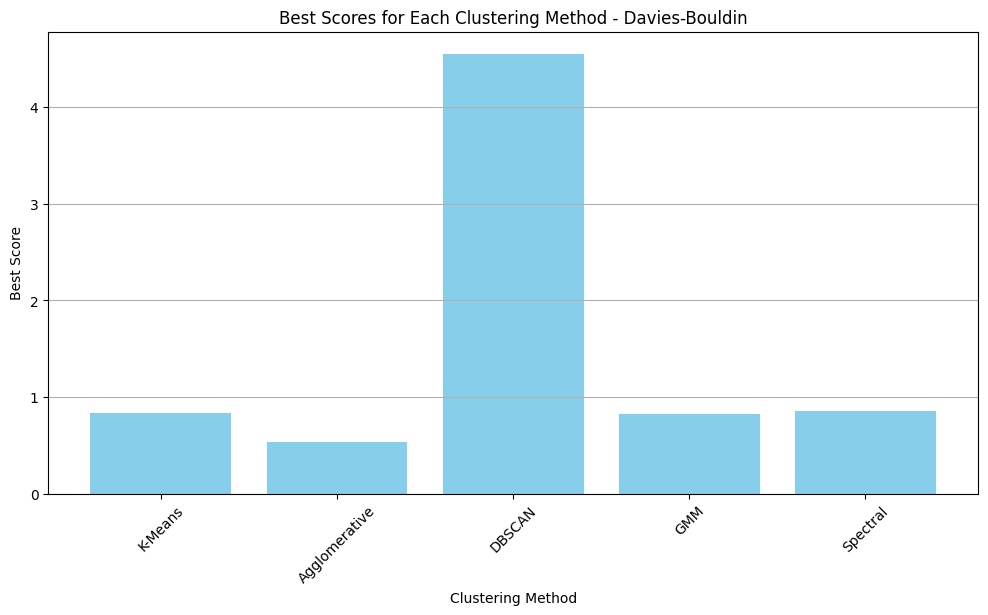

In [49]:
import matplotlib.pyplot as plt

# Data to plot
methods = list(best_hyperparameters.keys())
pca_components = [best_hyperparameters[method]['pca'] for method in methods]
scores = [best_hyperparameters[method]['score'][1] for method in methods]  # Using the first score for plotting

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('Best Scores for Each Clustering Method - Davies-Bouldin')
plt.xlabel('Clustering Method')
plt.ylabel('Best Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


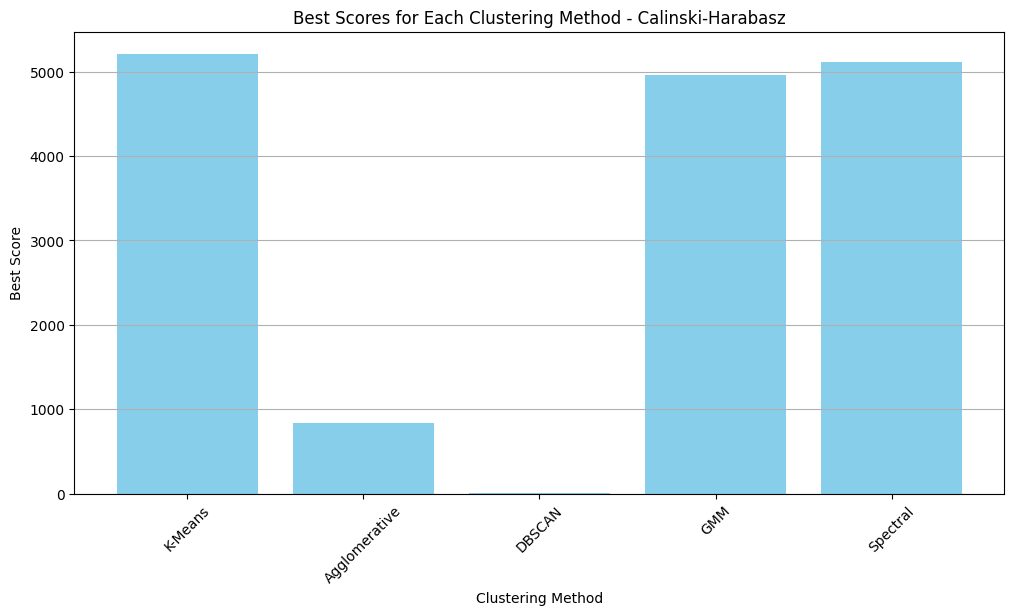

In [50]:
import matplotlib.pyplot as plt

# Data to plot
methods = list(best_hyperparameters.keys())
pca_components = [best_hyperparameters[method]['pca'] for method in methods]
scores = [best_hyperparameters[method]['score'][2] for method in methods]  # Using the first score for plotting

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('Best Scores for Each Clustering Method - Calinski-Harabasz')
plt.xlabel('Clustering Method')
plt.ylabel('Best Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


In [51]:
# Best clustering method: K-Means
best_method = "K-Means"
best_pca_components = 2
best_parameters = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3, 'n_init': 10}
best_score = (0.40443286145861834, 0.8298231240610466, 5212.267717603587)

# Apply K-Means with the best parameters
kmeans = KMeans(init=best_parameters['init'], max_iter=best_parameters['max_iter'], 
                n_clusters=best_parameters['n_clusters'], n_init=best_parameters['n_init'], random_state=42)
labels = kmeans.fit_predict(reduced_data)

# Calculate intra-cluster variances
intra_variances = []
n_clusters = best_parameters['n_clusters']  # Use the number of clusters from parameters
for k in range(n_clusters):
    cluster_data = reduced_data[labels == k]
    intra_variance = np.var(cluster_data, axis=0).mean()  # Mean variance of features
    intra_variances.append(intra_variance)

# Intra-group variance
variance_intra = np.mean(intra_variances)

# Calculate cluster centers
centers = kmeans.cluster_centers_

# Inter-group variance
mean_center = np.mean(centers, axis=0)
variance_inter = np.var(centers, axis=0).mean()  # Mean variance of centers

# Calculate the ratio
ratio = variance_inter / variance_intra

print(f"Variance Intra-Groupes: {variance_intra}")
print(f"Variance Inter-Groupes: {variance_inter}")
print(f"Ratio: {ratio}")


Variance Intra-Groupes: 2.239027214294898
Variance Inter-Groupes: 3.47646804372618
Ratio: 1.5526689544150851


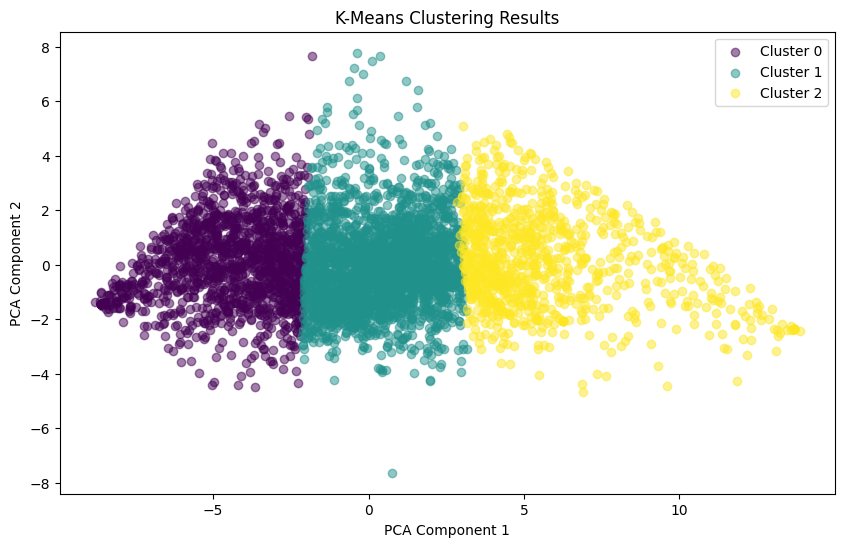

In [52]:
import matplotlib.pyplot as plt

# Plot the reduced data with cluster labels
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Updated to use viridis directly

for i, label in enumerate(unique_labels):
    if label == -1:  # Noise points
        color = 'k'  # Black for noise
    else:
        color = colors[i]  # Use the index to get the color
    plt.scatter(reduced_data[labels == label, 0], reduced_data[labels == label, 1], 
                color=color, label=f'Cluster {label}' if label != -1 else 'Noise', alpha=0.5)

plt.title('K-Means Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [55]:
# Assuming 'data' is your DataFrame and 'labels' are the cluster labels
subset_data['Cluster'] = labels  # Convert labels to a list before adding to the DataFrame

# Group by cluster and calculate summary statistics
cluster_summary = subset_data.groupby('Cluster').agg(['mean', 'std', 'count'])

# Display the summary statistics for each cluster
print(cluster_summary)

# Calculate the importance of each feature for each cluster
importance_summary = {}

for label in unique_labels:
    if label != -1:  # Skip noise points
        cluster_data = subset_data[subset_data['Cluster'] == label]
        importance = cluster_data.drop(columns=['Cluster']).mean()  # Calculate mean for each feature
        importance_summary[label] = importance

# Convert the summary to a DataFrame for better visualization
importance_df = pd.DataFrame(importance_summary).T

# Create a summary of the most important features for each cluster
importance_summary_str = {}

for label in unique_labels:
    if label != -1:  # Skip noise points
        # Get the importance of features for the current cluster
        importance = importance_df.loc[label]
        # Sort features by importance
        sorted_importance = importance.sort_values(ascending=False)
        # Create a summary string for the top features
        summary = ', '.join([f'{feature} : {value:.1f}' for feature, value in sorted_importance.items()])
        importance_summary_str[label] = summary

# Display the importance summary for each cluster
print("Importance Summary for Each Cluster:")
for label in importance_summary_str.keys():
    # Get the top 5 features for the current cluster
    top_features = importance_df.loc[label].nlargest(5)
    # Check the most common value for these features in the cluster
    most_common_values = {feature: subset_data[subset_data['Cluster'] == label][feature].mode()[0] for feature in top_features.index}
    print(f'Cluster {label}: {top_features.index.tolist()} with most common values: {most_common_values}')


        A9_1_slice                 A9_2_slice                 A9_3_slice  \
              mean       std count       mean       std count       mean   
Cluster                                                                    
0         1.600424  0.593215  1414   2.062942  0.758718  1414   2.016973   
1         2.236713  0.598308  2653   2.751979  0.676251  2653   2.699962   
2         3.056806  0.742624   933   3.511254  0.599653   933   3.531618   

                        A9_4_slice  ... A11_10_slice A11_11_slice            \
              std count       mean  ...        count         mean       std   
Cluster                             ...                                       
0        0.779965  1414   1.942008  ...         1414     1.553748  0.582485   
1        0.698298  2653   2.636261  ...         2653     2.290991  0.573206   
2        0.558121   933   3.509110  ...          933     3.147910  0.680498   

              A11_12_slice                 A11_13_slice             

/tmp/ipykernel_19443/2211454646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Cluster'] = labels  # Convert labels to a list before adding to the DataFrame


### **Cluster 0 :**  
#### **Features principales**  
- **A10_6_slice** (Les espaces extérieurs sont surtout des sources de contraintes) : *Plutôt pas d’accord* (3)  
- **A9_5_slice** (Je préfère que les espaces extérieurs soient plutôt sauvages que très entretenus) : *Plutôt pas d’accord* (3)  
- **A9_12_slice** (J’investis beaucoup d’argent dans l’aménagement et l’entretien de mes espaces extérieurs) : *Plutôt d’accord* (2)  
- **A10_3_slice** (Les espaces extérieurs sont avant tout des espaces utilitaires) : *Plutôt d’accord* (2)  
- **A9_13_slice** (Il m’arrive de regarder des vidéos, des tutoriels de jardinage sur Internet) : *Plutôt d’accord* (2)  

#### **Description**  
Ce cluster regroupe des individus qui :  
- Ne perçoivent pas les espaces extérieurs comme étant des sources de contraintes.  
- Préfèrent un entretien modéré des espaces extérieurs, plutôt que des espaces totalement sauvages.  
- Investissent raisonnablement dans l’aménagement de leurs espaces extérieurs.  
- Considèrent les espaces extérieurs comme utilitaires et recherchent parfois des informations en ligne pour les entretenir ou les aménager.  

---

### **Cluster 1 :**  
#### **Features principales**  
- **A9_12_slice** (J’investis beaucoup d’argent dans l’aménagement et l’entretien de mes espaces extérieurs) : *Plutôt pas d’accord* (3)  
- **A9_13_slice** (Il m’arrive de regarder des vidéos, des tutoriels de jardinage sur Internet) : *Plutôt pas d’accord* (3)  
- **A9_2_slice** (Je m’intéresse beaucoup aux nouveautés concernant l’aménagement des espaces extérieurs) : *Plutôt pas d’accord* (3)  
- **A9_5_slice** (Je préfère que les espaces extérieurs soient plutôt sauvages que très entretenus) : *Plutôt pas d’accord* (3)  
- **A9_3_slice** (Je recherche souvent des informations sur l’aménagement des espaces extérieurs) : *Plutôt pas d’accord* (3)  

#### **Description**  
Ce cluster regroupe des individus qui :  
- Investissent peu dans l’aménagement et l’entretien de leurs espaces extérieurs.  
- Sont peu intéressés par les nouveautés liées à l’aménagement des espaces extérieurs ou par la recherche d’informations sur le sujet.  
- Ne préfèrent pas particulièrement des espaces extérieurs sauvages ni trop entretenus.  
- Ne consomment pas de contenus numériques (vidéos, tutoriels) en rapport avec le jardinage ou l’aménagement des espaces extérieurs.  

---

### **Cluster 2 :**  
#### **Features principales**  
- **A9_13_slice** (Il m’arrive de regarder des vidéos, des tutoriels de jardinage sur Internet) : *Pas du tout d’accord* (4)  
- **A9_12_slice** (J’investis beaucoup d’argent dans l’aménagement et l’entretien de mes espaces extérieurs) : *Pas du tout d’accord* (4)  
- **A9_3_slice** (Je recherche souvent des informations sur l’aménagement des espaces extérieurs) : *Pas du tout d’accord* (4)  
- **A9_2_slice** (Je m’intéresse beaucoup aux nouveautés concernant l’aménagement des espaces extérieurs) : *Pas du tout d’accord* (4)  
- **A9_4_slice** (Je recherche souvent des informations sur l’entretien des espaces extérieurs) : *Pas du tout d’accord* (4)  

#### **Description**  
Ce cluster regroupe des individus qui :  
- Ont un désintérêt marqué pour les espaces extérieurs, ne s’impliquant pas dans leur aménagement ou leur entretien.  
- N’investissent pas financièrement dans leurs espaces extérieurs.  
- Ne recherchent ni d’informations ni de tutoriels concernant le jardinage ou l’entretien des espaces extérieurs.  
- Ne s’intéressent pas aux nouveautés liées aux espaces extérieurs.  

---

### **Résumé global**  
- **Cluster 0 :** Approche modérée envers les espaces extérieurs, perçus comme utilitaires, avec un intérêt occasionnel pour leur entretien.  
- **Cluster 1 :** Désintérêt global pour l’aménagement et l’entretien des espaces extérieurs, sans rejet total mais avec un faible investissement personnel et financier.  
- **Cluster 2 :** Rejet complet de l’investissement, de l’entretien et de l’intérêt pour les espaces extérieurs.  

# Conclusion
Dans le cadre de notre analyse de clustering, nous avons réalisé un benchmark en utilisant plusieurs métriques de performance : Silhouette, Davies-Bouldin et Calinski-Harabasz. Nous avons appliqué différentes méthodes de clustering, notamment KMeans, Agglomerative Clustering, DBSCAN, Gaussian Mixture Model et Spectral Clustering.  
Les résultats de cette évaluation ont montré que le Kmeans offrait les meilleures performances globales selon les métriques analysées (surtout pour 3 clusters). En conséquence, nous avons décidé de nous concentrer sur cette méthode. 
 
En termes de variance, nous avons obtenu les résultats suivants : 
- Variance Intra-Groupes: 2.239
- Variance Inter-Groupes: 3.476
- Ratio: 1.553
 
Ces résultats soulignent l'efficacité du KMeans dans notre analyse.